In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import jaxrl_m.envs
import gym
%precision %.3f


'%.3f'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
# np array with shape (frames, height, width, channels)
def create_video(ims):
    video = np.array(ims)

    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=500)
    return anim

In [3]:
env = gym.make("sort-easy-v0", disp=True)


2024-04-22 11:39:47.709171: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 11:39:47.739037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 11:39:48.119262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/max/anaconda3/envs/offline/lib/python3.8/site-packages/transforms3d/quaternions.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior an

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.105.17
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 525.105.17
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
text argument:dependencies/ravens/ravens/environments/assets
int args: [

load datafile: 100%|██████████| 8/8 [00:00<00:00, 172.85it/s]

ven = NVIDIA Corporation


ven = NVIDIA Corporation


In [4]:
from jaxrl_m.learners.d4rl_utils import new_get_trj_idx
import d4rl
import numpy as np
# dataset = env.get_dataset()
dataset = d4rl.qlearning_dataset(env)
eps=0.01
lim = 1 - eps
dataset["actions"] = np.clip(dataset["actions"], -lim, lim)

imputed_next_observations = np.roll(dataset["observations"], -1, axis=0)
same_obs = np.all(
    np.isclose(imputed_next_observations, dataset["next_observations"], atol=1e-5),
    axis=-1,
)
dones_float = 1.0 - same_obs.astype(np.float32)
dones_float[-1] = 1

dones_float = dataset["terminals"].astype(np.float32)
dataset = {
    "observations": dataset["observations"],
    "actions": dataset["actions"],
    "rewards": dataset["rewards"],
    "masks": 1.0 - dataset["terminals"],
    "dones_float": dones_float,
    "next_observations": dataset["next_observations"],
}

load datafile: 100%|██████████| 8/8 [00:00<00:00, 187.93it/s]


Dones are not dropped


Getting trj idx: 100%|██████████| 199999/199999 [00:00<00:00, 6304443.22it/s]


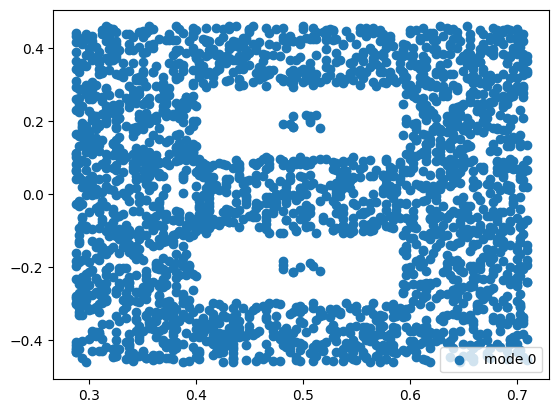

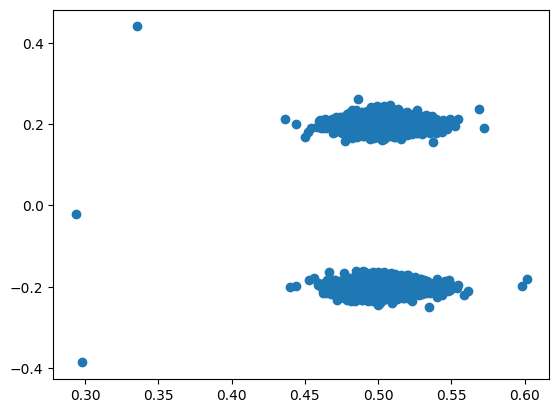

In [5]:
traj_id = new_get_trj_idx(dataset)
start_ids = [t[0] for t in traj_id]
end_ids = [t[1] for t in traj_id]
init_poses = np.stack([dataset["observations"][i] for i in start_ids])
init_x = init_poses[:, 3]
init_y = init_poses[:, 4]

last_poses = np.stack([dataset["observations"][i] for i in end_ids])
last_x = last_poses[:, 3]
last_y = last_poses[:, 4]
mode_0 = np.argwhere(last_y > 0)
mode_1 = np.argwhere(last_y < 0)

import matplotlib.pyplot as plt
# plt.scatter(init_x, init_y)
plt.scatter(init_x[mode_0], init_y[mode_0], label="mode 0")
# plt.scatter(init_x[mode_1], init_y[mode_1], label="mode 1")
plt.legend()
plt.show()

plt.scatter(last_x, last_y)
plt.show()

in_dist_poses = init_poses[mode_0]

In [6]:
import jaxrl_m.learners.iql as learner
from jaxrl_m.evaluation import supply_rng, evaluate
from functools import partial

model_path = "ravens/ravens-sort-easy/GC/GC_iql_sort-easy-v0_20240422_113103"
agent = learner.load_learner(
        seed=42,
        model_path=model_path,
        discount=0.99,
        temperature=10.0,
        expectile=0.7,
        tau=0.1,
    )

/home/max/anaconda3/envs/offline/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
2024-04-22 11:39:51.738242: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
import numpy as np
def generate_trajectory(env, policy_fn, i, oracle):
    mode = np.random.choice([0, 1])
    env.set_mode(mode)
    env.unwrapped.task.debug = True
    env.unwrapped.task.initial_pose = (in_dist_poses[i][0][3:6], (0, 0, 0, 1))
    obs = env.reset()
    oracle.reset()
    done = False
    actions = []
    block_poses = []
    ee_poses = []
    adv1 = []
    adv2 = []
    reward = []
    pose = []
    ims = []
    while not done:
        obs = np.concatenate((obs, np.zeros(1)+mode))
        action = policy_fn(obs)
        if type(action) == dict:
            # action_dict = action
            next_obs, r, done, info = env.step_oracle(action)
            pos, rot = action["move_cmd"]
            suction = action["suction_cmd"]
            action_min, action_max = env.action_stats["min"], env.action_stats["max"]
            action = np.concatenate([np.array(pos), np.array([suction])]).flatten()
            action = (action - action_min) / (action_max - action_min)
            action = action * 2 - 1
        else:
            action = action.flatten()
            next_obs, r, done, info = env.step(action)
        q1_actual, q2_actual = agent.critic(obs, action)
        v = agent.value(obs)
        actions.append(action)
        block_poses.append(obs[3:6])
        ee_poses.append(obs[0:3])
        adv1.append(q1_actual - v)
        adv2.append(q2_actual - v)
        reward.append(info["dense_reward"])
        obs = next_obs
        im = env.render(mode="rgb_array")
        ims.append(im)

    video = create_video(ims)
    return adv1, adv2, reward, block_poses, ee_poses, actions, video
    

In [14]:
import matplotlib.pyplot as plt
def plot(ax, val1, val2, title):
    ax.plot(val1, label="IQL")
    ax.plot(val2, label="Oracle")
    ax.set_title(title)

/home/max/anaconda3/envs/offline/lib/python3.8/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


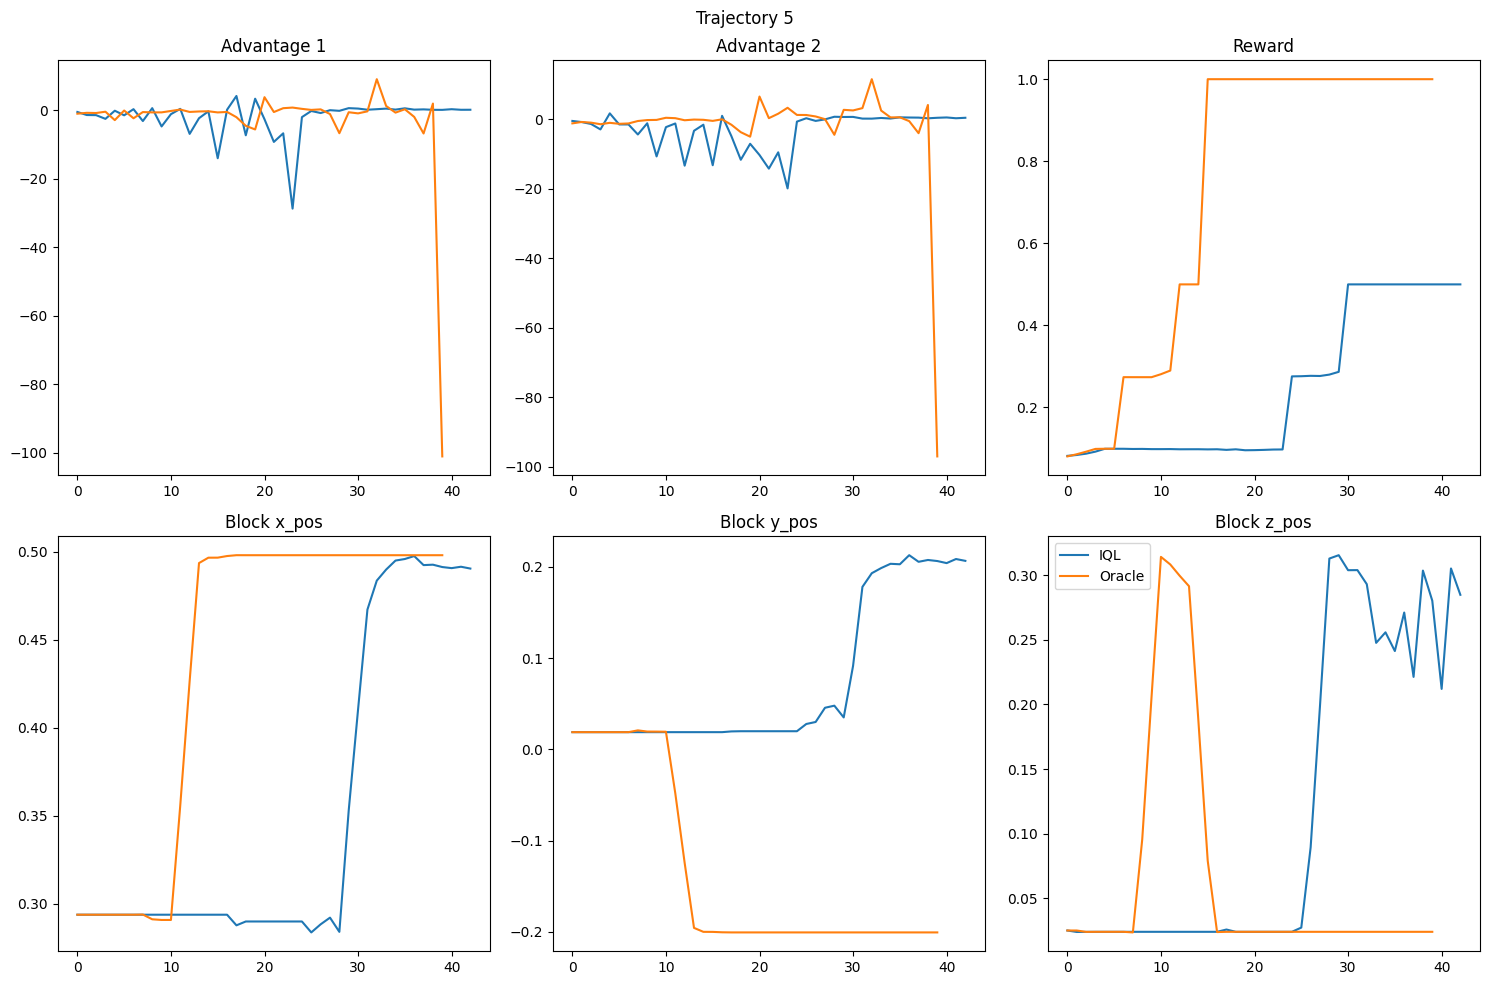

In [15]:
orl_policy = partial(supply_rng(agent.sample_actions), temperature=0.0)
task = env.unwrapped.task
oracle = task.oracle(env.unwrapped.env, steps_per_seg=3)
oracle_policy = lambda x: oracle.act(x, {})

for i in range(5, 6):
    try:
        adv1_orl, adv2_orl, r_orl, pos_orl, ee_orl, action_orl, video_orl = generate_trajectory(env, orl_policy, i, oracle)
        adv1_oracle, adv2_oracle, r_oracle, pos_oracle, ee_oracle, action_oracle, video_oracle = generate_trajectory(env, oracle_policy, i, oracle)
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        axs = axs.flatten()
        plot(axs[0], adv1_orl, adv1_oracle, "Advantage 1")
        plot(axs[1], adv2_orl, adv2_oracle, "Advantage 2")
        plot(axs[2], r_orl, r_oracle, "Reward")
        
        block_labels = ["x_pos", "y_pos", "z_pos"]
        for j in range(3):
            plot(axs[3+j], [x[j] for x in pos_orl], [x[j] for x in pos_oracle], f"Block {block_labels[j]}")
        #for j in range(3):
        #    plot(axs[6+j], [x[j] for x in ee_orl], [x[j] for x in ee_oracle], f"EE {block_labels[j]}")
        #action_labels = ["x_pos", "y_pos", "z_pos", "q1_pos", "q2_pos", "q3_pos", "q4_pos", "suction"]
        #for j in range(4):
        #    plot(axs[9+j], [x[j] for x in action_orl], [x[j] for x in action_oracle], f"Action {action_labels[j]}")
        plt.legend()
        plt.suptitle(f"Trajectory {i}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(e)
        continue


In [ ]:
HTML(video_orl.to_html5_video())

In [ ]:
HTML(video_oracle.to_html5_video())

In [ ]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)


traj_id = 2#np.random.randint(len(dataset["init_poses"]))
traj_obs = dataset["observations"][4*traj_id: 4*traj_id+4]
traj_act = dataset["actions"][4*traj_id: 4*traj_id+4]
traj_init_pose = dataset["init_poses"][traj_id]
init_pose_obs = []
for i in range(4):
    o = traj_init_pose[i*3: (i+1)*3]
    init_pose_obs.append(o[:3])

KeyError: 'init_poses'

In [ ]:
import time
# import numpy as np

env.env.task.init_pose(init_pose_obs)
env.unwrapped.env.reset()
obs = env.get_obs()

for i in range(4):
    print("Step", i)
    # if i < 4:
    #     print("True actions")
    #     v = agent.value(traj_obs[i])
    #     q1, q2 = agent.critic(traj_obs[i], traj_act[i])
    #     print("value", v)
    #     print("q1", q1)
    #     print("q2", q2)
    #     print("\n")


    
    act = supply_rng(agent.sample_actions)(obs, temperature=0.0)#agent.actor()#policy_fn(obs)
    act = np.array(act)
    # act[1] -= 0.015
    actual_action = supply_rng(agent.sample_actions)(traj_obs[i], temperature=0.0)
    
    print("Policy actions")
    v = agent.value(traj_obs[i])
    q1, q2 = agent.critic(obs, act)
    q1_actual, q2_actual = agent.critic(traj_obs[i], actual_action)
    q1_oracle, q2_oracle = agent.critic(traj_obs[i], traj_act[i])
    q1_oracle2, q2_oracle2 = agent.critic(obs, traj_act[i])
    print("obs, pi_act", min(q1, q2))
    # print("traj_obs, pi_act", min(q1_actual, q2_actual))
    # print("traj_obs, traj_act", min(q1_oracle, q2_oracle))
    print("obs, traj_act", min(q1_oracle2, q2_oracle2))
    print("act diff", (act - traj_act[i]))

    # print("value", v)
    # print("q1", min(q1, q2))
    # # print("q2", q2)
    # # print("\n")
    # print("Q values actual")
    # print("q1", min(q1_actual, q2_actual))
    # # print("q2", q2_actual)
    # # print("\n")
    # print("Q values oracle")
    # print("q1", q1_oracle)
    # print("q2", q2_oracle)
    # print("Q values oracle2")
    # print("q1", q1_oracle2)
    # print("q2", q2_oracle2)

    print("\n\n")
    # if i==0:
    #     act = traj_act[i]
    obs,_,_,_ = env.step(traj_act[i])
    # print(act)
    time.sleep(0.2)
    # break

Step 0
Policy actions
obs, pi_act 5.603261
obs, traj_act 16.527002
act diff [ 0.373  0.198  0.45  -0.    -0.    -1.068  1.173  0.   ]



suction 0
move (0.35513842, -0.010213017, 0.23566666)
rotate [-0.     0.     0.988 -0.154]


Step 1
Policy actions
obs, pi_act 2.0360491
obs, traj_act 0.62955695
act diff [ 0.12  -0.008 -1.075  0.001  0.002 -1.235  0.838  0.   ]



suction 0
move (0.35513842, -0.010213017, 0.345)
rotate [-0.     0.     0.963 -0.268]


Step 2
Policy actions
obs, pi_act 1.8341916
obs, traj_act 0.91660815
act diff [-0.043 -0.229 -0.733 -0.005  0.002 -1.22   1.205  0.   ]



suction 0
move (0.40407166, 0.062227666, 0.33666667)
rotate [-0.     0.     0.789 -0.614]


Step 3
Policy actions
obs, pi_act 6.7947426
obs, traj_act 8.259279
act diff [-0.147 -0.381 -0.39   0.002  0.    -1.044  1.604  0.009]



suction 0
move (0.45300487, 0.13466829, 0.32833332)
rotate [-0.     0.     0.392 -0.92 ]




In [ ]:
print(act - traj_act[0])

[ 0.122 -0.077  0.148  0.002  0.    -1.665  0.817  0.009]


In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from jaxrl_m.evaluation import evaluate
from functools import partial
from jaxrl_m.learners.iql import load_learner
import gym
import jaxrl_m.envs
from jaxrl_m.evaluation import supply_rng, evaluate

model_path = "ravens_debug/ravens-test/iql/iql_iql_sort-debug-v0_20240327_113744/checkpoint_250000"
agent = load_learner(
        seed=42,
        model_path=model_path,
        discount=0.99,
        temperature=10.0,
        expectile=0.7,
        tau=0.1,
    )

env = gym.make("sort-debug2-v0")
policy_fn = partial(supply_rng(agent.sample_actions), temperature=0.0)
evaluate(policy_fn, env, num_episodes=100)


TypeError: 'NoneType' object is not subscriptable